In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install faiss-cpu
!pip install -q "supervision==0.26.0rc4"

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info, fetch_image, extract_vision_info
import torch

import requests
from io import BytesIO
from PIL import Image
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1.Load Model

In [ ]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"

qwen_model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

qwen_processor = AutoProcessor.from_pretrained(model_name, min_pixels=256*28*28, max_pixels=512*28*28)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Common function

In [ ]:
def generate_text_from_image(image_path, text):
    """
    Generates text from an image and a given prompt using the DeepSeek-VL2 model.

    Args:
        image_path (str): Path to the input image.
        text (str): Text prompt/question for the model.
    Returns:
        str: The generated text response.
    """

    # Prepare the input messages (conversation format)
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": text},
        ],
    }
    ]

    # Apply chat template formatting
    formatted_text = qwen_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process images and prepare inputs
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = qwen_processor(
        text=[formatted_text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        dynamic_resolution=True
    )
    inputs = inputs.to("cuda")

    # Model inference
    generated_ids = qwen_model.generate(**inputs, max_new_tokens=1024)

    # Trim generated tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the output
    output_text = qwen_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    input_h = inputs['image_grid_thw'][0][1] * 14
    input_w = inputs['image_grid_thw'][0][2] * 14

    return output_text[0], (input_w, input_h)

In [ ]:
def load_image_from_google_driver(url):
    # Check if it's a Google Drive sharing link and extract the actual download link
    if "drive.google.com/file/d/" in url:
        id = url.split("/d/")[1].split("/")[0]
        url = f"https://drive.google.com/uc?export=download&id={id}"

    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    image = Image.open(BytesIO(response.content))
    return image

In [ ]:
def draw_bounding_box(image, bbox, label, target_size, color=(0, 255, 0), thickness=2, font_scale=0.5, font=cv2.FONT_HERSHEY_SIMPLEX):
    """
    Draws a bounding box with a label on an image.

    Args:
        image (np.ndarray): The image on which to draw.
        bbox (dict): Dictionary containing bounding box parameters.
                     Expected format: {'x': int, 'y': int, 'width': int, 'height': int}
        label (str): Label text for the bounding box.
        color (tuple): Color of the bounding box in BGR (default green).
        thickness (int): Thickness of the bounding box outline.
        font_scale (float): Font scale for the label text.
        font: OpenCV font to use for the label text.

    Returns:
        np.ndarray: The image with the drawn bounding box and label.
    """
    # Make a copy of the image to avoid modifying the original

    w, h = image_w_h
    # .to_numpy
    w, h = int(w.cpu().numpy()), int(h.cpu().numpy())

    annotated_image = np.array(image.copy())

    # Extract values from bbox dictionary
    x = bbox['x']
    y = bbox['y']
    width = bbox['width']
    height = bbox['height']

    # Calculate bottom-right coordinates
    x2 = x + width
    y2 = y + height

    # Draw the rectangle (bounding box)
    cv2.rectangle(annotated_image, (x, y), (x2, y2), color, thickness)

    # Prepare the label: get text size to create a background rectangle
    (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)

    # Draw a filled rectangle for the text background (above the bounding box)
    cv2.rectangle(annotated_image, (x, y - text_height - baseline - 4), (x + text_width, y), color, -1)

    # Put the label text over the filled rectangle
    cv2.putText(annotated_image, label, (x, y - 2), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    return annotated_image

# 2.Hands-on

## 2.1 Visual Question Answering

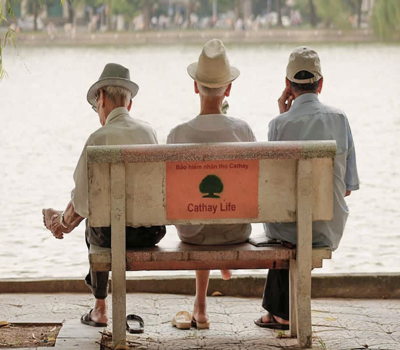

In [ ]:
image_url = "https://drive.google.com/file/d/1I86YHFyI667Cu5CARlRBrUDi3xDuFrnl/view?usp=sharing"
image = load_image_from_google_driver(image_url)

image = image.resize((400, 350))
image

In [ ]:
PROMPT = """
How many people are in the picture?.
"""

result, _ = generate_text_from_image(image, PROMPT)

In [ ]:
result

'There are three people in the picture.'

## 2.2 Object Detection

In [ ]:
image_url = "https://drive.google.com/file/d/1TpbSYcVnxVQF9_kGhhfhiLIgflbnFJZK/view?usp=sharing"
image = load_image_from_google_driver(image_url)

In [ ]:
PROMPT = """
Please analyze the provided image and identify the location of the cat. Return the bounding box coordinates as a JSON dictionary with keys ‘x’, ‘y’, ‘width’, and ‘height’, where (x, y) represents the top-left corner of the box and ‘width’ and ‘height’ represent its dimensions. Only return the JSON output.
"""

result, image_w_h = generate_text_from_image(image, PROMPT)

Output format from model
```json
{
  "x": 250,
  "y": 300,
  "width": 200,
  "height": 200
}
```

In [ ]:
print(result)

json_string = result.replace("```", "")[4:]
json_string = json.loads(json_string)
draw_bounding_box(image, json_string, "cat", image_w_h)

```json
{
  "x": 250,
  "y": 300,
  "width": 200,
  "height": 200
}
```


array([[[ 17,  21,  22],
        [ 15,  19,  22],
        [ 14,  19,  23],
        ...,
        [ 68,  68,  60],
        [ 61,  62,  56],
        [ 53,  55,  50]],

       [[ 17,  21,  22],
        [ 15,  19,  22],
        [ 14,  19,  23],
        ...,
        [ 68,  67,  63],
        [ 64,  65,  60],
        [ 58,  58,  56]],

       [[ 17,  21,  22],
        [ 16,  20,  23],
        [ 14,  19,  23],
        ...,
        [ 66,  66,  68],
        [ 65,  65,  65],
        [ 60,  60,  60]],

       ...,

       [[138, 127, 133],
        [138, 127, 133],
        [138, 127, 135],
        ...,
        [113, 100, 107],
        [112,  99, 108],
        [112,  99, 108]],

       [[136, 127, 132],
        [135, 126, 131],
        [135, 126, 131],
        ...,
        [114,  99, 104],
        [114,  99, 104],
        [114,  99, 104]],

       [[135, 126, 131],
        [134, 125, 130],
        [134, 125, 130],
        ...,
        [115,  99, 100],
        [116, 100, 101],
        [117, 101, 101]]], dtype=uint8)
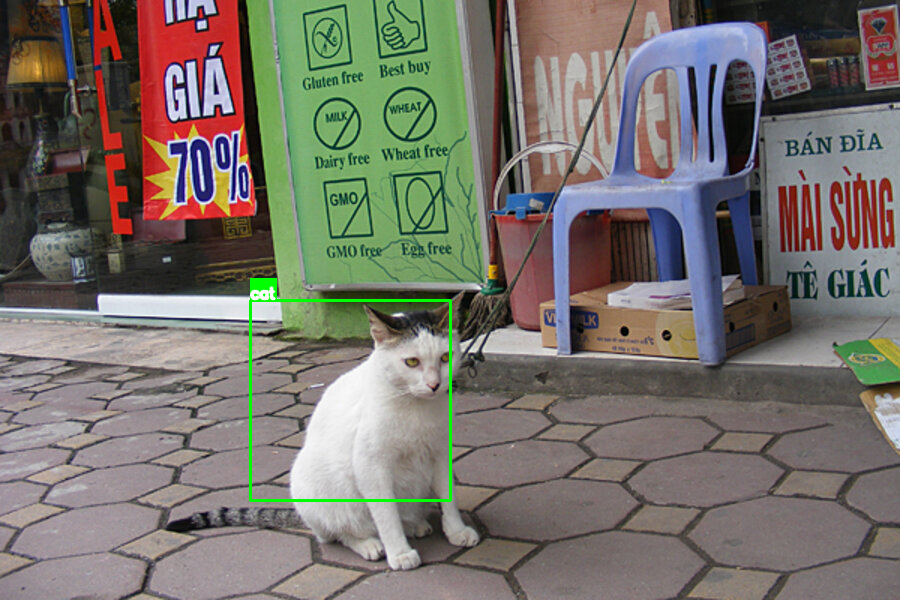

## 2.3 Elictric Bill

In [ ]:
image_url = "https://drive.google.com/file/d/1ABmoxHXT5Cc6qUvivTSxiD5-w7GwXSkr/view?usp=sharing"
image = load_image_from_google_driver(image_url)

In [ ]:
PROMPT = "Please analyze the provided electric bill and extract total amount of bill. Structure the extracted data into a well-formatted JSON output with appropriate keys and values."
result, _ = generate_text_from_image(image, PROMPT)

In [ ]:
print(result)

```json
{
  "bill_number": "AE/18E",
  "date": "19/10/2018",
  "company_name": "Công Ty Điện Lực Vĩnh Long - Điện Lực Vũng Liêm",
  "customer_number": "01GTKT0001",
  "customer_name": "Số 59 Nam Kỳ Khởi Nghĩa, khu 1, thị trấn Vũng Liêm, huyện Vũng Liêm, tỉnh Vĩnh Long",
  "customer_address": "Số 1-10 xã Trung Ngãi - huyện Vũng Liêm",
  "customer_phone": "0300942001-021",
  "customer_email": "19001006",
  "customer_id": "66559",
  "total_amount": 562903
}
```


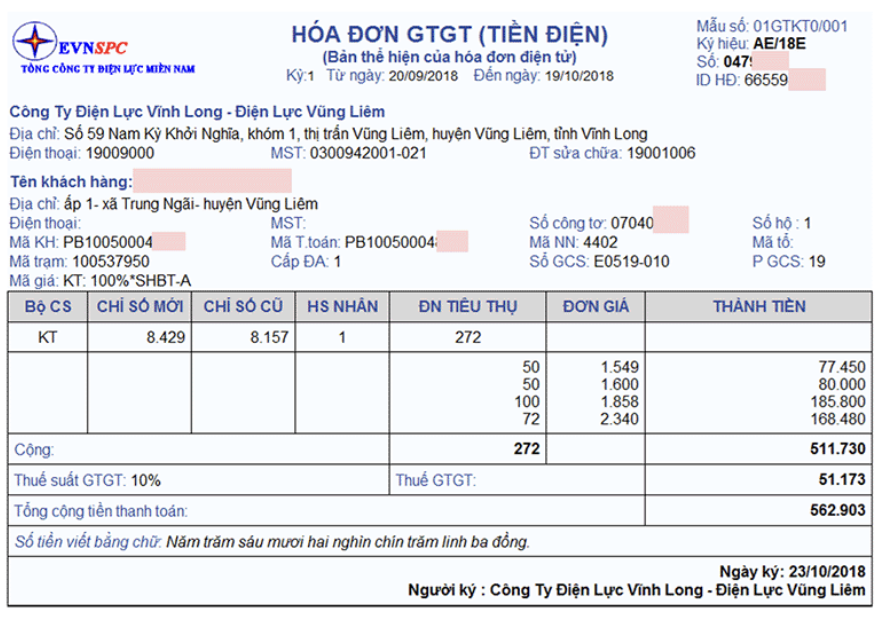

In [ ]:
image